In [1]:
import sys
import os
import numpy as np
import networkx as nx
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Import the mis function from the util module in the parent folder
from util import mis, generate_run_name

class GraphEnvironment(gym.Env):
    def __init__(self, num_nodes=7):
        super(GraphEnvironment, self).__init__()
        self.num_nodes = num_nodes
        self.max_edges = num_nodes * (num_nodes - 1) // 2
        self.action_space = spaces.Discrete(self.max_edges)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.int8)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.num_nodes))
        self.available_edges = list(nx.non_edges(self.G))
        return self._get_observation(), {}

    def step(self, action):
        if action < len(self.available_edges):
            edge = self.available_edges[action]
            self.G.add_edge(*edge)
            self.available_edges.pop(action)

        terminated = len(self.available_edges) == 0
        observation = self._get_observation()
        reward = self._calculate_reward() if terminated else 0
        info = {}

        return observation, reward, terminated, False, info

    def _get_observation(self):
        return nx.to_numpy_array(self.G, dtype=np.int8)

    def _count_steps(self):
        def count_steps_recursive(G):
            step_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
            
            def recursive_mis(G):
                step_counts[1] += 1
                if len(G) == 0:
                    return set()
                
                degrees = dict(G.degree())
                if not degrees:
                    return set()
                
                if max(degrees.values()) <= 2:
                    step_counts[2] += 1
                    return set()
                
                step_counts[3] += 1
                degree_one_nodes = [n for n, d in degrees.items() if d == 1]
                if degree_one_nodes:
                    step_counts[4] += 1
                    v = degree_one_nodes[0]
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(v)) - {v}))
                    return
                
                step_counts[5] += 1
                if not nx.is_connected(G):
                    step_counts[6] += 1
                    components = list(nx.connected_components(G))
                    G1 = G.subgraph(components[0])
                    step_counts[7] += 1
                    recursive_mis(G1)
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G1.nodes())))
                    return
                
                step_counts[8] += 1
                step_counts[9] += 1
                max_degree_node = max(degrees, key=degrees.get)
                step_counts[10] += 1
                recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(max_degree_node)) - {max_degree_node}))
                recursive_mis(G.subgraph(set(G.nodes()) - {max_degree_node}))
            
            recursive_mis(G)
            return step_counts

        return count_steps_recursive(self.G)

    def _calculate_reward(self):
        step_counts = self._count_steps()
        line_10_calls = step_counts[10]
        total_steps = sum(step_counts.values())
        return line_10_calls / max(total_steps, 1)

    def render(self):
        plt.figure(figsize=(6, 4))
        nx.draw(self.G, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
        plt.title(f"Generated Graph (Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()})")
        plt.show()

class TrainingVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingVisualizationCallback, self).__init__(verbose)
        self.rewards = []
        self.losses = []

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Update every 1000 steps
            self.rewards.append(np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer]))
            self.losses.append(self.model.logger.name_to_value['train/loss'])
            self._plot_training_progress()
        return True

    def _plot_training_progress(self):
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        ax1.plot(self.rewards)
        ax1.set_title('Average Reward')
        ax1.set_xlabel('Thousand Steps')
        ax1.set_ylabel('Reward')
        
        ax2.plot(self.losses)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Thousand Steps')
        ax2.set_ylabel('Loss')
        
        plt.tight_layout()
        plt.show()

def evaluate_agent(model, env, num_episodes=5):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        print(f"Episode {i+1}")
        env.render()
        run_name = generate_run_name(env.G)
        mis_result = mis(env.G, visualize=True, verbose=True, run_name=run_name)
        step_counts = env._count_steps()
        print(f"MIS size: {len(mis_result)}")
        print(f"Line 10 calls: {step_counts[10]}")
        print(f"Total steps: {sum(step_counts.values())}")
        print(f"Proportion of line 10 calls: {step_counts[10] / sum(step_counts.values()):.2f}")
        print(f"Reward: {env._calculate_reward():.4f}")
        print("--------------------")

# Create and wrap the environment
env = DummyVecEnv([lambda: GraphEnvironment(num_nodes=10)])

# Initialize the agent with a larger network
policy_kwargs = dict(net_arch=[128, 128, 128])
model = PPO("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=1e-4, n_steps=2048)

# Train the agent for more timesteps
model.learn(total_timesteps=500000)

# Evaluate the agent
evaluate_agent(model, env.envs[0], num_episodes=10)

# Save the trained model
model.save("graph_generation_model_10nodes")

# To load the model later, you can use:
# model = PPO.load("graph_generation_model_10nodes")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5820 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 3569       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01007233 |
|    clip_fraction        | 0.0736     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.8       |
|    explained_variance   | 0.26815826 |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0538    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 0.00787    |
----------------------------------------
-----------------------------------

KeyboardInterrupt: 

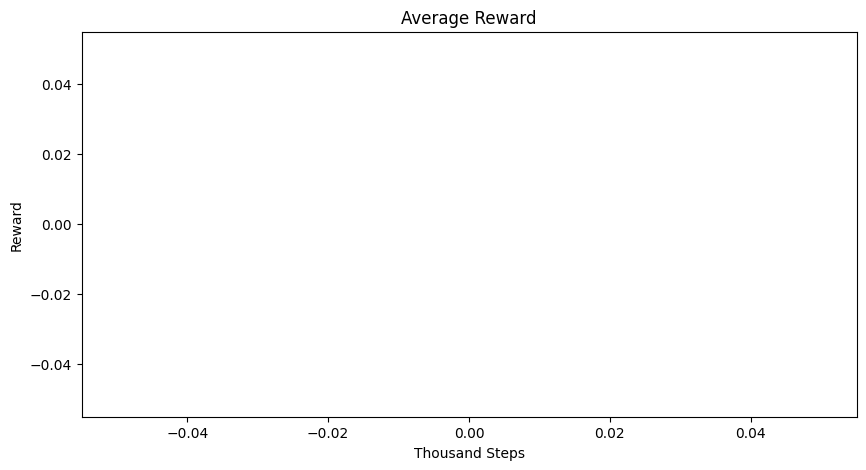

----------------------------------------
| time/                   |            |
|    fps                  | 2936       |
|    iterations           | 32         |
|    time_elapsed         | 22         |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.04388247 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.21      |
|    explained_variance   | 0.8476833  |
|    learning_rate        | 0.001      |
|    loss                 | 0.195      |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0747    |
|    value_loss           | 0.677      |
----------------------------------------


In [2]:
import numpy as np
import networkx as nx
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

class SimplifiedGraphEnvironment(gym.Env):
    def __init__(self, num_nodes=10):
        super(SimplifiedGraphEnvironment, self).__init__()
        self.num_nodes = num_nodes
        self.max_edges = num_nodes * (num_nodes - 1) // 2
        self.action_space = spaces.Discrete(self.max_edges)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.int8)
        self.current_step = 0
        self.max_steps = self.max_edges // 2  # Allow only half of the possible edges

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.num_nodes))
        self.available_edges = list(nx.non_edges(self.G))
        self.current_step = 0
        return self._get_observation(), {}

    def step(self, action):
        self.current_step += 1
        
        if action < len(self.available_edges):
            edge = self.available_edges[action]
            self.G.add_edge(*edge)
            self.available_edges.pop(action)

        observation = self._get_observation()
        reward = self._calculate_reward()
        terminated = self.current_step >= self.max_steps
        info = {}

        return observation, reward, terminated, False, info

    def _get_observation(self):
        return nx.to_numpy_array(self.G, dtype=np.int8)

    def _calculate_reward(self):
        # Simplified reward: encourage a specific graph property
        # For example, let's aim for a graph with average degree close to 2
        avg_degree = np.mean([d for n, d in self.G.degree()])
        return -abs(avg_degree - 2)  # Negative distance from target average degree

    def render(self):
        plt.figure(figsize=(6, 4))
        nx.draw(self.G, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
        plt.title(f"Generated Graph (Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()})")
        plt.show()

class TrainingVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingVisualizationCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Update every 1000 steps
            self.rewards.append(np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer]))
            self._plot_training_progress()
        return True

    def _plot_training_progress(self):
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(self.rewards)
        plt.title('Average Reward')
        plt.xlabel('Thousand Steps')
        plt.ylabel('Reward')
        plt.show()

def evaluate_agent(model, env, num_episodes=5):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated
        
        print(f"Episode {i+1}")
        env.render()
        print(f"Total Reward: {total_reward:.4f}")
        print(f"Average Degree: {np.mean([d for n, d in env.G.degree()]):.2f}")
        print("--------------------")

# Create and wrap the environment
env = DummyVecEnv([lambda: SimplifiedGraphEnvironment(num_nodes=10)])

# Initialize the agent
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, n_steps=2048)

# Create a callback for visualization
vis_callback = TrainingVisualizationCallback()

# Train the agent
model.learn(total_timesteps=500000, callback=vis_callback)

# Evaluate the agent
evaluate_agent(model, env.envs[0], num_episodes=5)

# Save the trained model
model.save("simplified_graph_generation_model")

# To load the model later, you can use:

# model = PPO.load("simplified_graph_generation_model")

KeyboardInterrupt: 

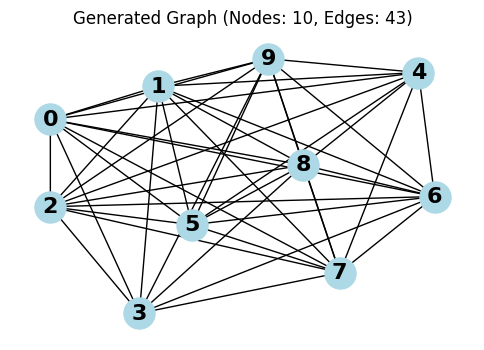

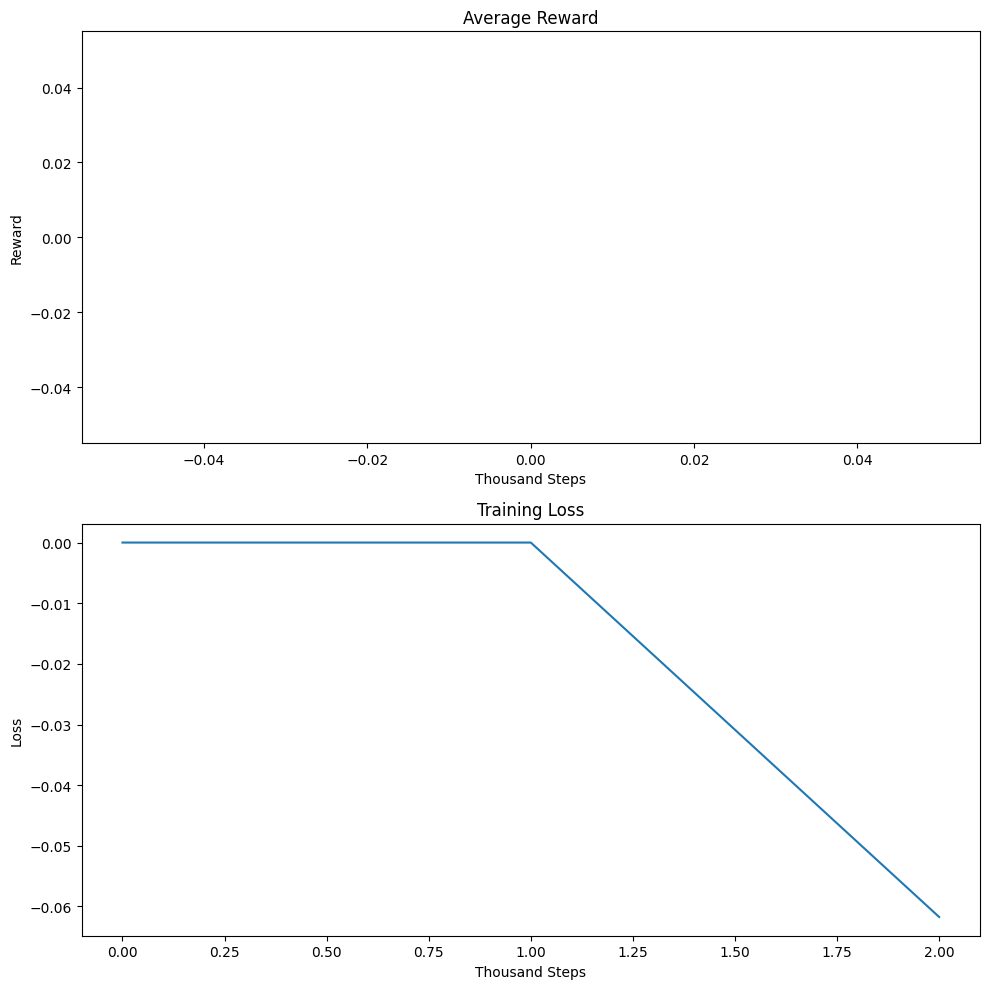

In [2]:
import sys
import os
import numpy as np
import networkx as nx
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Import the mis function from the util module in the parent folder
from util import mis, generate_run_name

class GraphEnvironment(gym.Env):
    def __init__(self, num_nodes=7):
        super(GraphEnvironment, self).__init__()
        self.num_nodes = num_nodes
        self.max_edges = num_nodes * (num_nodes - 1) // 2
        self.action_space = spaces.Discrete(self.max_edges)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.int8)
        self.fig, self.ax = plt.subplots(figsize=(6, 4))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.num_nodes))
        self.available_edges = list(nx.non_edges(self.G))
        self._render_graph()
        return self._get_observation(), {}

    def step(self, action):
        if action < len(self.available_edges):
            edge = self.available_edges[action]
            self.G.add_edge(*edge)
            self.available_edges.pop(action)

        terminated = len(self.available_edges) == 0
        observation = self._get_observation()
        reward = self._calculate_reward() if terminated else 0
        info = {}

        self._render_graph()
        return observation, reward, terminated, False, info

    def _get_observation(self):
        return nx.to_numpy_array(self.G, dtype=np.int8)

    def _count_steps(self):
        def count_steps_recursive(G):
            step_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
            
            def recursive_mis(G):
                step_counts[1] += 1
                if len(G) == 0:
                    return set()
                
                degrees = dict(G.degree())
                if not degrees:
                    return set()
                
                if max(degrees.values()) <= 2:
                    step_counts[2] += 1
                    return set()
                
                step_counts[3] += 1
                degree_one_nodes = [n for n, d in degrees.items() if d == 1]
                if degree_one_nodes:
                    step_counts[4] += 1
                    v = degree_one_nodes[0]
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(v)) - {v}))
                    return
                
                step_counts[5] += 1
                if not nx.is_connected(G):
                    step_counts[6] += 1
                    components = list(nx.connected_components(G))
                    G1 = G.subgraph(components[0])
                    step_counts[7] += 1
                    recursive_mis(G1)
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G1.nodes())))
                    return
                
                step_counts[8] += 1
                step_counts[9] += 1
                max_degree_node = max(degrees, key=degrees.get)
                step_counts[10] += 1
                recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(max_degree_node)) - {max_degree_node}))
                recursive_mis(G.subgraph(set(G.nodes()) - {max_degree_node}))
            
            recursive_mis(G)
            return step_counts

        return count_steps_recursive(self.G)

    def _calculate_reward(self):
        step_counts = self._count_steps()
        line_10_calls = step_counts[10]
        total_steps = sum(step_counts.values())
        return line_10_calls / max(total_steps, 1)

    def _render_graph(self):
        self.ax.clear()
        nx.draw(self.G, ax=self.ax, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
        self.ax.set_title(f"Generated Graph (Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()})")
        clear_output(wait=True)
        display(self.fig)

    def render(self):
        pass  # We don't need this method anymore as we're rendering at each step

class TrainingVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingVisualizationCallback, self).__init__(verbose)
        self.rewards = []
        self.losses = []
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(10, 10))

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Update every 1000 steps
            self.rewards.append(np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer]))
            self.losses.append(self.model.logger.name_to_value['train/loss'])
            self._plot_training_progress()
        return True

    def _plot_training_progress(self):
        self.ax1.clear()
        self.ax2.clear()
        
        self.ax1.plot(self.rewards)
        self.ax1.set_title('Average Reward')
        self.ax1.set_xlabel('Thousand Steps')
        self.ax1.set_ylabel('Reward')
        
        self.ax2.plot(self.losses)
        self.ax2.set_title('Training Loss')
        self.ax2.set_xlabel('Thousand Steps')
        self.ax2.set_ylabel('Loss')
        
        self.fig.tight_layout()
        clear_output(wait=True)
        display(self.fig)

def evaluate_agent(model, env, num_episodes=5):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        print(f"Episode {i+1}")
        run_name = generate_run_name(env.G)
        mis_result = mis(env.G, visualize=True, verbose=True, run_name=run_name)
        step_counts = env._count_steps()
        print(f"MIS size: {len(mis_result)}")
        print(f"Line 10 calls: {step_counts[10]}")
        print(f"Total steps: {sum(step_counts.values())}")
        print(f"Proportion of line 10 calls: {step_counts[10] / sum(step_counts.values()):.2f}")
        print(f"Reward: {env._calculate_reward():.4f}")
        print("--------------------")

# Create and wrap the environment
env = DummyVecEnv([lambda: GraphEnvironment(num_nodes=10)])

# Initialize the agent with a larger network
policy_kwargs = dict(net_arch=[128, 128, 128])
model = PPO("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=1e-4, n_steps=2048)

# Train the agent for more timesteps
vis_callback = TrainingVisualizationCallback()
model.learn(total_timesteps=500000, callback=vis_callback)

# Evaluate the agent
evaluate_agent(model, env.envs[0], num_episodes=10)

# Save the trained model
model.save("graph_generation_model_10nodes")

# To load the model later, you can use:
# model = PPO.load("graph_generation_model_10nodes")

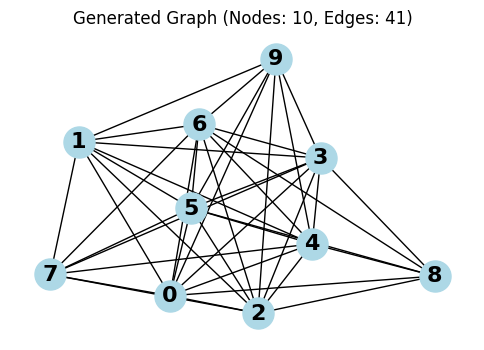

KeyboardInterrupt: 

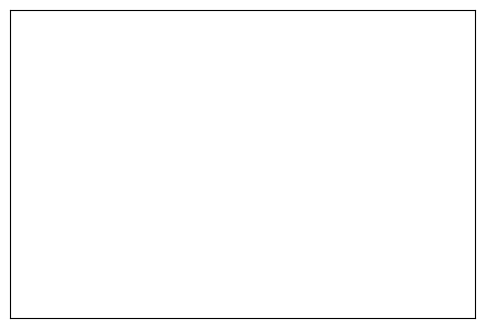

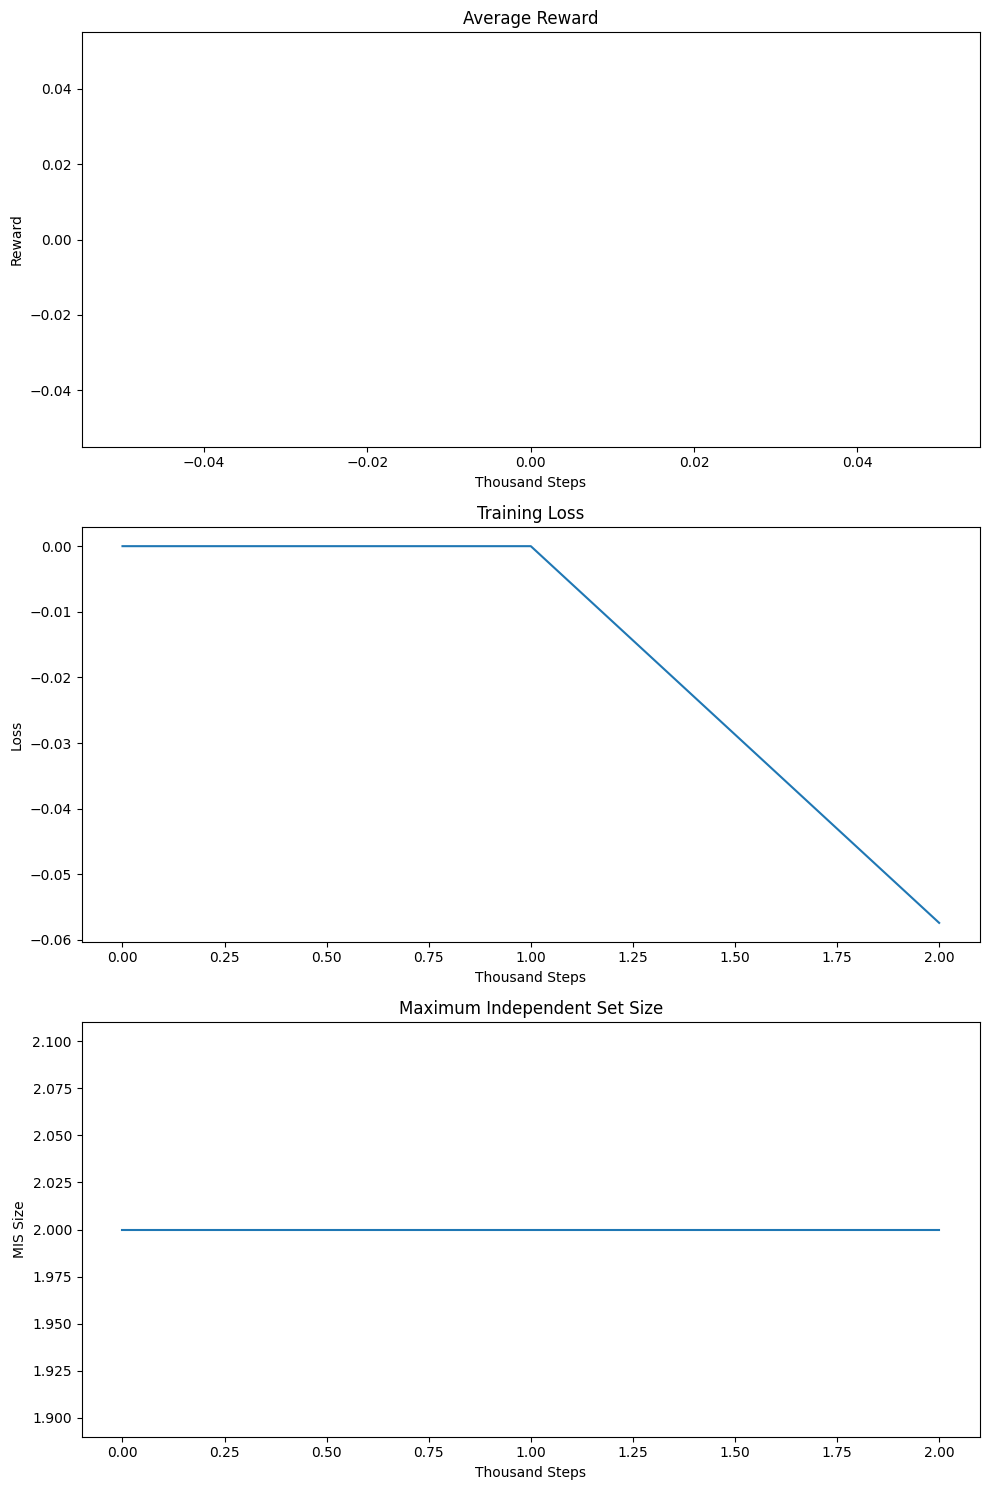

In [7]:
import sys
import os
import numpy as np
import networkx as nx
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Import the mis function from the util module in the parent folder
from util import mis, generate_run_name

class GraphEnvironment(gym.Env):
    def __init__(self, num_nodes=7):
        super(GraphEnvironment, self).__init__()
        self.num_nodes = num_nodes
        self.max_edges = num_nodes * (num_nodes - 1) // 2
        self.action_space = spaces.Discrete(self.max_edges)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.int8)
        self.fig, self.ax = plt.subplots(figsize=(6, 4))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.num_nodes))
        self.available_edges = list(nx.non_edges(self.G))
        self._render_graph()
        return self._get_observation(), {}

    def step(self, action):
        if action < len(self.available_edges):
            edge = self.available_edges[action]
            self.G.add_edge(*edge)
            self.available_edges.pop(action)

        terminated = len(self.available_edges) == 0
        observation = self._get_observation()
        reward = self._calculate_reward() if terminated else 0
        info = {}

        self._render_graph()
        return observation, reward, terminated, False, info

    def _get_observation(self):
        return nx.to_numpy_array(self.G, dtype=np.int8)

    def _count_steps(self):
        def count_steps_recursive(G):
            step_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
            
            def recursive_mis(G):
                step_counts[1] += 1
                if len(G) == 0:
                    return set()
                
                degrees = dict(G.degree())
                if not degrees:
                    return set()
                
                if max(degrees.values()) <= 2:
                    step_counts[2] += 1
                    return set()
                
                step_counts[3] += 1
                degree_one_nodes = [n for n, d in degrees.items() if d == 1]
                if degree_one_nodes:
                    step_counts[4] += 1
                    v = degree_one_nodes[0]
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(v)) - {v}))
                    return
                
                step_counts[5] += 1
                if not nx.is_connected(G):
                    step_counts[6] += 1
                    components = list(nx.connected_components(G))
                    G1 = G.subgraph(components[0])
                    step_counts[7] += 1
                    recursive_mis(G1)
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G1.nodes())))
                    return
                
                step_counts[8] += 1
                step_counts[9] += 1
                max_degree_node = max(degrees, key=degrees.get)
                step_counts[10] += 1
                recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(max_degree_node)) - {max_degree_node}))
                recursive_mis(G.subgraph(set(G.nodes()) - {max_degree_node}))
            
            recursive_mis(G)
            return step_counts

        return count_steps_recursive(self.G)

    def _calculate_reward(self):
        step_counts = self._count_steps()
        line_10_calls = step_counts[10]
        total_steps = sum(step_counts.values())
        return line_10_calls / max(total_steps, 1)

    def _render_graph(self):
        self.ax.clear()
        nx.draw(self.G, ax=self.ax, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
        self.ax.set_title(f"Generated Graph (Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()})")
        clear_output(wait=True)
        display(self.fig)

    def render(self):
        pass  # We don't need this method anymore as we're rendering at each step

class TrainingVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingVisualizationCallback, self).__init__(verbose)
        self.rewards = []
        self.losses = []
        self.mis_sizes = []
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(10, 15))

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Update every 1000 steps
            self.rewards.append(np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer]))
            self.losses.append(self.model.logger.name_to_value['train/loss'])
            # Calculate MIS size for the current graph
            current_graph = self.training_env.envs[0].G
            mis_size = len(mis(current_graph))
            self.mis_sizes.append(mis_size)
            self._plot_training_progress()
        return True

    def _plot_training_progress(self):
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        
        self.ax1.plot(self.rewards)
        self.ax1.set_title('Average Reward')
        self.ax1.set_xlabel('Thousand Steps')
        self.ax1.set_ylabel('Reward')
        
        self.ax2.plot(self.losses)
        self.ax2.set_title('Training Loss')
        self.ax2.set_xlabel('Thousand Steps')
        self.ax2.set_ylabel('Loss')
        
        self.ax3.plot(self.mis_sizes)
        self.ax3.set_title('Maximum Independent Set Size')
        self.ax3.set_xlabel('Thousand Steps')
        self.ax3.set_ylabel('MIS Size')
        
        self.fig.tight_layout()
        clear_output(wait=True)
        display(self.fig)

def evaluate_agent(model, env, num_episodes=5):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        print(f"Episode {i+1}")
        run_name = generate_run_name(env.G)
        mis_result = mis(env.G, visualize=True, verbose=True, run_name=run_name)
        step_counts = env._count_steps()
        print(f"MIS size: {len(mis_result)}")
        print(f"Line 10 calls: {step_counts[10]}")
        print(f"Total steps: {sum(step_counts.values())}")
        print(f"Proportion of line 10 calls: {step_counts[10] / sum(step_counts.values()):.2f}")
        print(f"Reward: {env._calculate_reward():.4f}")
        print("--------------------")

# Create and wrap the environment
env = DummyVecEnv([lambda: GraphEnvironment(num_nodes=10)])

# Initialize the agent with a larger network
policy_kwargs = dict(net_arch=[128, 128, 128])
model = PPO("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=1e-4, n_steps=2048)

# Train the agent for more timesteps
vis_callback = TrainingVisualizationCallback()
model.learn(total_timesteps=500000, callback=vis_callback)

# Evaluate the agent
evaluate_agent(model, env.envs[0], num_episodes=10)

# Save the trained model
model.save("graph_generation_model_10nodes")

# To load the model later, you can use:
# model = PPO.load("graph_generation_model_10nodes")